In [1]:
import os
import pandas as pd
from fastai.vision.all import *
from fastai.vision import models
from fastai.metrics import error_rate, accuracy

import warnings
warnings.filterwarnings("ignore")
set_seed(42)

print ('modules loaded')

modules loaded


In [2]:
data_dir = 'Original'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

,filepaths,labels
0,Original\Benign\WBC-Benign-001.jpg,Benign
1,Original\Benign\WBC-Benign-002.jpg,Benign
2,Original\Benign\WBC-Benign-003.jpg,Benign
3,Original\Benign\WBC-Benign-004.jpg,Benign
4,Original\Benign\WBC-Benign-005.jpg,Benign
...,...,...
3251,Original\Pro\WBC-Malignant-Pro-800.jpg,Pro
3252,Original\Pro\WBC-Malignant-Pro-801.jpg,Pro
3253,Original\Pro\WBC-Malignant-Pro-802.jpg,Pro
3254,Original\Pro\WBC-Malignant-Pro-803.jpg,Pro


In [4]:
dls = ImageDataLoaders.from_df(df,
                                fn_col=0, # filepaths
                                label_col=1, # labels
                                valid_pct=0.2,
                                folder='', 
                                item_tfms=Resize(224))

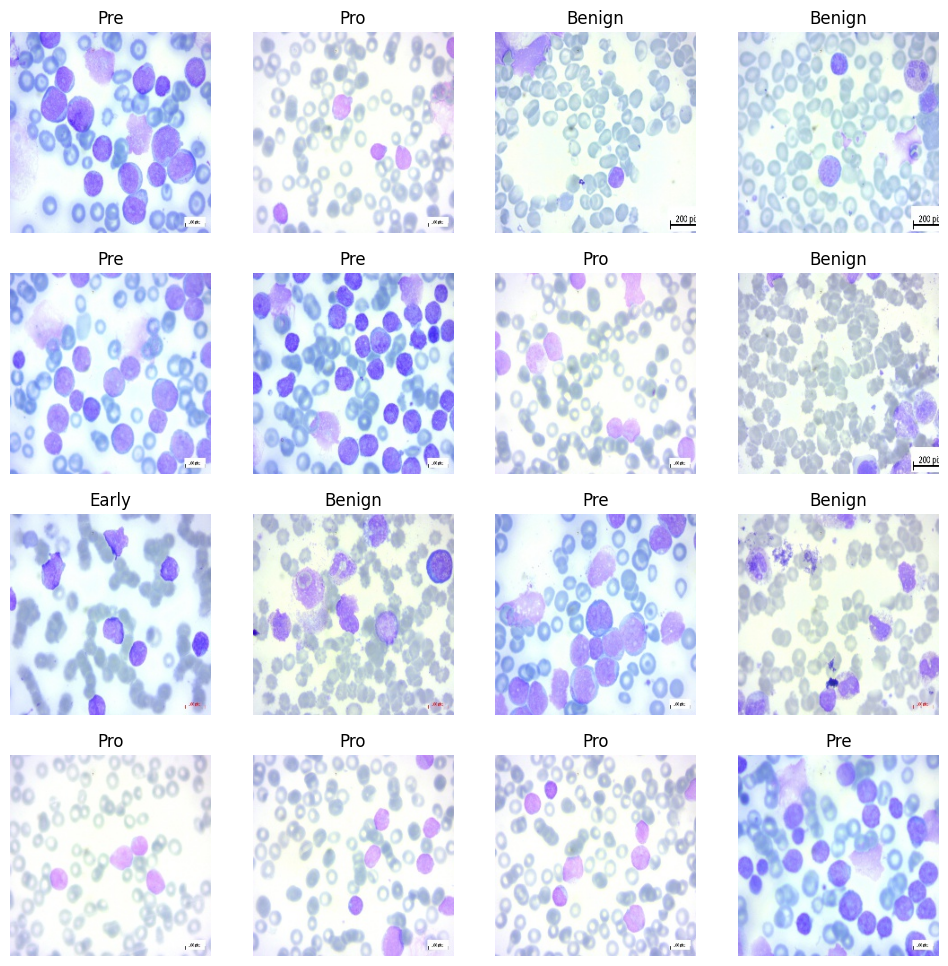

In [5]:
dls.show_batch(max_n=16)

In [6]:
from fastai.vision.all import *

# Define the path to your data folder
path = Path('Original')

# Create DataLoaders (assuming images are organized into folders representing their class)
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(128), batch_tfms=aug_transforms())

# Create the learner
learn = vision_learner(dls, 'efficientnet_b3', metrics=[accuracy, error_rate], path='.').to_fp16()

# Show the model summary
learn.summary()


Sequential (Input shape: 64 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 40 x 64 x 64   
Conv2d                                    1080       False     
Identity                                                       
SiLU                                                           
Conv2d                                    360        False     
Identity                                                       
SiLU                                                           
Identity                                                       
____________________________________________________________________________
                     64 x 10 x 1 x 1     
Conv2d                                    410        False     
SiLU                                                           
____________________________________________________________________________
                     64 x 40 x 1 x 1     
Conv2d                             

In [7]:
import timm

SuggestedLRs(valley=0.001737800776027143, slide=0.015848932787775993)

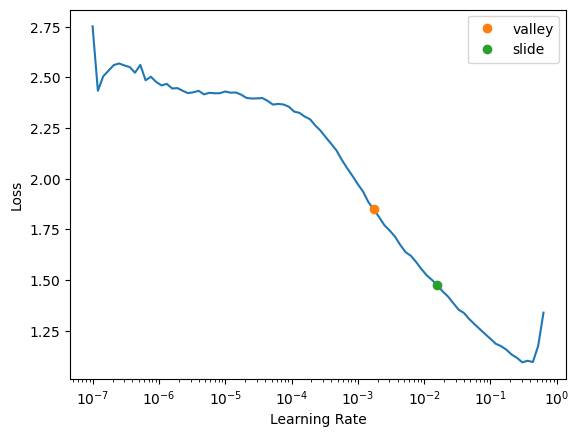

In [8]:
learn.lr_find(suggest_funcs=(valley, slide))
'''valley represents the point where the loss is at its minimum, and 
slide refers to the steepness of the curve as it approaches the minimum, 
helping to identify the optimal learning rate.'''

In [9]:
# Use the learning rate from valley or slide
learn.fit_one_cycle(20, lr_max=0.0158)



epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.663626,0.355228,0.909370,0.090630,03:39
1,0.438693,0.346245,0.910906,0.089094,04:47
2,0.329313,0.187930,0.950845,0.049155,04:34
3,0.235249,0.107315,0.970814,0.029186,04:22
4,0.183320,0.149770,0.953917,0.046083,09:38
5,0.152376,0.083463,0.978495,0.021505,10:09
6,0.140271,0.111606,0.980031,0.019969,10:03
7,0.101194,0.167391,0.955453,0.044547,09:41
8,0.079849,0.108749,0.978495,0.021505,09:43
9,0.070259,0.167705,0.967742,0.032258,09:36


In [10]:
print(learn.recorder.values)

[[0.6636258959770203, 0.3552284836769104, 0.9093701839447021, 0.09062980115413666], [0.43869340419769287, 0.34624484181404114, 0.9109063148498535, 0.08909370005130768], [0.32931333780288696, 0.18793047964572906, 0.9508448243141174, 0.04915514588356018], [0.2352493554353714, 0.1073145866394043, 0.9708141088485718, 0.029185868799686432], [0.1833198219537735, 0.14976981282234192, 0.9539170265197754, 0.04608295112848282], [0.1523762047290802, 0.08346322923898697, 0.9784946441650391, 0.02150537632405758], [0.14027056097984314, 0.11160597950220108, 0.9800307154655457, 0.019969278946518898], [0.10119424760341644, 0.1673910766839981, 0.9554531574249268, 0.04454685002565384], [0.07984946668148041, 0.10874908417463303, 0.9784946441650391, 0.02150537632405758], [0.07025858014822006, 0.16770482063293457, 0.9677419066429138, 0.032258063554763794], [0.05824822559952736, 0.02961261384189129, 0.9907833933830261, 0.009216589853167534], [0.04368121922016144, 0.0278371199965477, 0.9938555955886841, 0.006

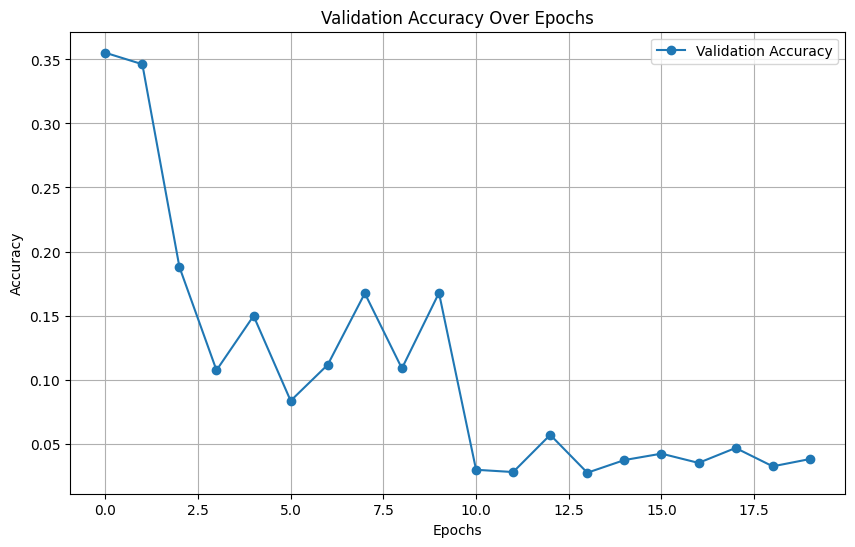

In [11]:
val_accuracies = [row[1] for row in learn.recorder.values]  # Index 1 for validation accuracy
epochs = range(len(val_accuracies))  # Number of epochs

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


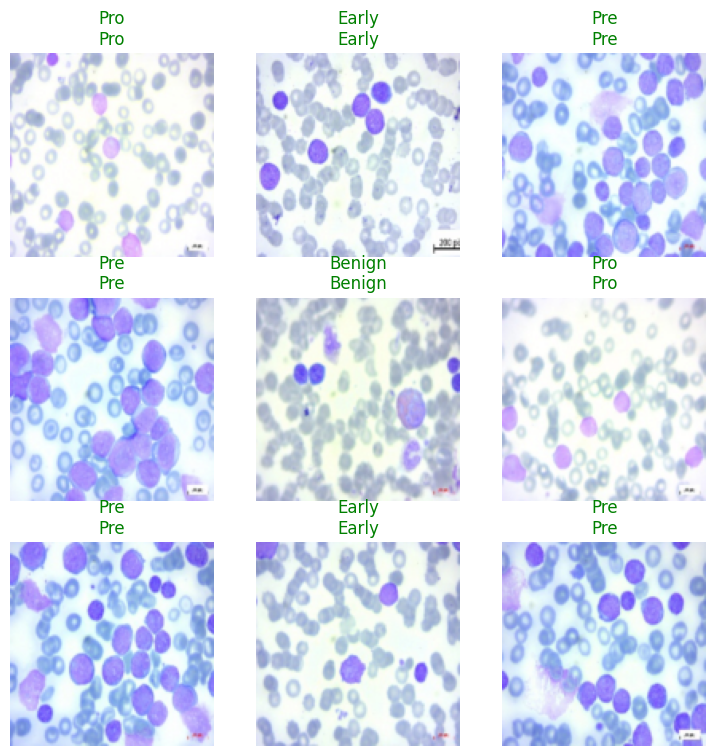

In [12]:
learn.show_results()

In [13]:
learn.export('ALLModel.pkl')

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

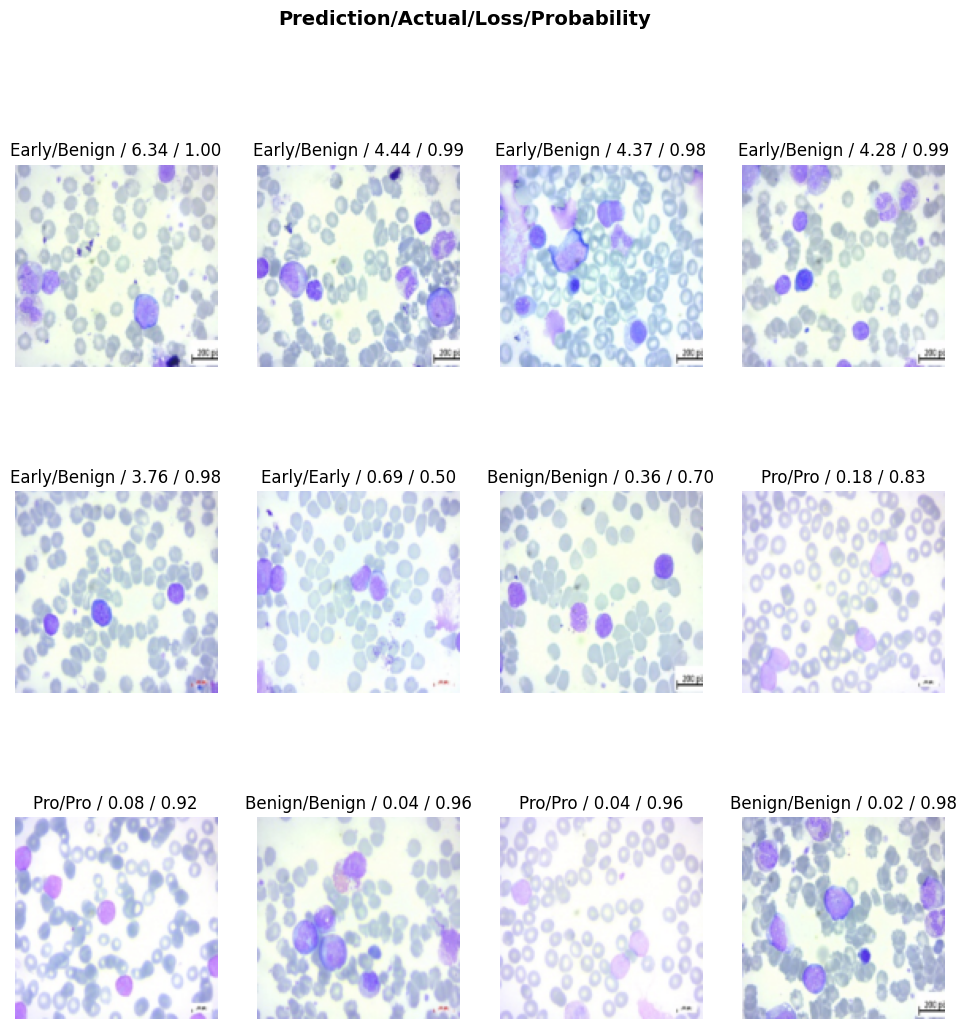

In [15]:
interp.plot_top_losses(12, figsize=(12,12))

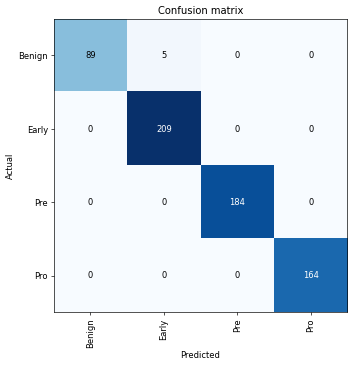

In [16]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [17]:
#To view the list of classes most misclassified as a list
interp.most_confused(min_val=2) #We are ignoring single image misclassification

#Sorted descending list of largest non-diagonal entries of confusion matrix, 
#presented as actual, predicted, number of occurrences.

[('Benign', 'Early', 5)]

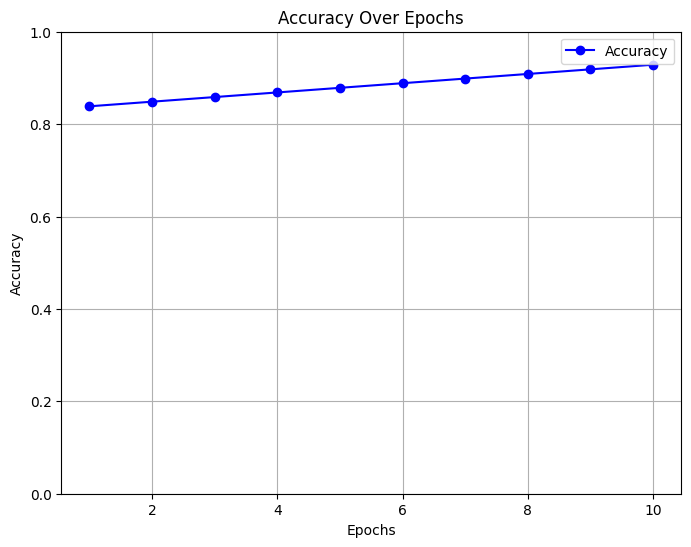

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Example confusion matrix
confusion_matrix = np.array([
    [50, 2, 1],
    [3, 45, 2],
    [2, 1, 48]
])

# Calculate accuracy
total = np.sum(confusion_matrix)
correct = np.trace(confusion_matrix)  # Sum of diagonal elements
accuracy = correct / total

# Simulate accuracies for multiple epochs (for demonstration)
epochs = range(1, 11)  # Assuming 10 epochs
accuracies = [accuracy - 0.01 * (10 - epoch) for epoch in epochs]  # Example trend

# Plot the accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracies, label="Accuracy", marker='o', color='b')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


In [24]:
from fastai.vision.all import *

# Load the exported model
learn = load_learner('AllModel.pkl')

# Load the image for testing
img_path = r"D:\programing\Jupyter notebook\win\Original\Pre\WBC-Malignant-Pre-002.jpg"

img = PILImage.create(img_path)

# Predict the class
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")


Prediction: Pre, Probability: 1.0000
